In [29]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Image

import os, sys, re, datetime
from pathlib import Path

pj_dir = Path(os.getcwd()).parents[0]
data_dir = pj_dir/'data'
img_dir = pj_dir/'images'
src_dir = pj_dir/'src'
sys.path.append(str(src_dir))

from matplotlib import pyplot as plt
plt.style.use("bmh")
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats 
import sqlalchemy as  sa
from google.cloud import bigquery

from tqdm import tqdm
from dotenv import load_dotenv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (16, 4)
import logging
logging.basicConfig(level=logging.INFO)
plt.rcParams["font.family"] = "IPAGothic"

from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [30]:
from itertools import product

In [90]:
df = pd.read_csv(data_dir/'pyconjp/talklist_forblog.csv')

In [91]:
id_room_ref = {
    'ra': 'A+B会議室',
    'rb': '小展示ホール',
    'rc': '特別会議室',
    'rd1': 'コンベンションホール',
    'rd2': 'コンベンションホール 梅',
    'rd3': 'コンベンションホール 鶯',
    're': 'C会議室',
    'rf': 'D会議室'
}
room_id_ref = {room: id_ for id_, room in id_room_ref.items()}

In [92]:
room_id_ref['小展示'] = 'rb'

In [93]:
timelist = list(df.groupby(['発表日', '時間']).groups.keys())

In [94]:
tt_no_dict = {
 '1日目13:30 - 14:15': 1,
 '1日目14:30 - 15:15': 2,
 '1日目15:45 - 16:15': 3,
 '1日目16:30 - 17:00': 4,
 '2日目11:15 - 12:00': 1,
 '2日目13:30 - 14:15': 2,
 '2日目14:30 - 15:00': 3,
 '2日目15:45 - 16:15': 4,
 '2日目16:30 - 17:00': 5
}

In [95]:
talk_format_dict = {
 '1日目13:30 - 14:15': 45,
 '1日目14:30 - 15:15': 45,
 '1日目15:45 - 16:15': 30,
 '1日目16:30 - 17:00': 30,
 '2日目11:15 - 12:00': 45,
 '2日目13:30 - 14:15': 45,
 '2日目14:30 - 15:00': 30,
 '2日目15:45 - 16:15': 30,
 '2日目16:30 - 17:00': 30
}

In [96]:
df['no'] = (df['発表日'] + df['時間']).replace(tt_no_dict)

In [97]:
df['room_id'] = df['部屋'].replace(room_id_ref)

In [98]:
df['day'] = df['発表日'].replace({'1日目': 1, '2日目': 2})

In [99]:
df.columns

Index(['id', '名前', 'プロフィール/Your Profile', 'タイトル', 'トークの概要/Talk abstract',
       'audience_level', '発表資料の言語/Language of presentation materials',
       '発表で使用する言語/Presentation language', '発表日', '時間', '部屋', '階数',
       'description', 'tag', 'location', 'bio', 'organization', 'genre', 'no',
       'room_id', 'day'],
      dtype='object')

In [100]:
lang_of_slide_dict = {
    '日本語のみ/Japanese Only': 'ja',
    'English Only': 'en',
    '日本語と英語/Japanese and English': 'ja_en'
}

In [101]:
lang_of_talk_dict = {
    '日本語/Japanese': 'ja', 
    '英語/English': 'en'
}

In [102]:
df['name'] = df['名前']
df['room'] = df['部屋']
df['floor'] = df['階数']
df['title'] = df['タイトル']
df['abstract'] = df['トークの概要/Talk abstract']
df['profile'] = df['プロフィール/Your Profile']
df['abstract'] = df['トークの概要/Talk abstract']
df['talk_format'] = (df['発表日'] + df['時間']).replace(talk_format_dict)
df['lang_of_slide'] = df['発表資料の言語/Language of presentation materials'].replace(lang_of_slide_dict)
df['lang_of_talk'] = df['発表で使用する言語/Presentation language'].replace(lang_of_talk_dict)
df['tags'] = df['tag']

# 二日目のコンベンションルーム対応

In [103]:
df['no'].value_counts()

3    13
2    13
4    12
1    12
5     6
Name: no, dtype: int64

In [104]:
taget_index = df.query('day == 2').query('no == 1').query('room_id == "rd1"').index.values[0]

In [105]:
df.loc[taget_index, "room_id"] = 'rd2'

In [106]:
df.columns

Index(['id', '名前', 'プロフィール/Your Profile', 'タイトル', 'トークの概要/Talk abstract',
       'audience_level', '発表資料の言語/Language of presentation materials',
       '発表で使用する言語/Presentation language', '発表日', '時間', '部屋', '階数',
       'description', 'tag', 'location', 'bio', 'organization', 'genre', 'no',
       'room_id', 'day', 'name', 'room', 'floor', 'title', 'abstract',
       'profile', 'talk_format', 'lang_of_slide', 'lang_of_talk', 'tags'],
      dtype='object')

In [107]:
cols = [
    'id', 'name', 'title', 'abstract', 'talk_format', 'profile', 'room', 'day', 'no', 'room_id',
    'lang_of_slide', 'lang_of_talk', 'audience_level', 'tags', 'description'
]

In [108]:
df['date'] = df['発表日'] + ' ' + df['時間']

In [109]:
dates = df['date'].unique().tolist()

In [110]:
dates.sort()
dates

['1日目 13:30 - 14:15',
 '1日目 14:30 - 15:15',
 '1日目 15:45 - 16:15',
 '1日目 16:30 - 17:00',
 '2日目 11:15 - 12:00',
 '2日目 13:30 - 14:15',
 '2日目 14:30 - 15:00',
 '2日目 15:45 - 16:15',
 '2日目 16:30 - 17:00']

In [111]:
date_ = dates[0]

In [112]:
df.query('date == @date_')['lang_of_talk']

4     en
12    ja
26    ja
43    ja
44    en
51    ja
Name: lang_of_talk, dtype: object

In [113]:
df['genre'].value_counts()

7    12
0    12
3     9
5     7
1     7
2     5
6     2
4     2
Name: genre, dtype: int64

In [142]:
genre_dict = {
    0: 'ML,データ解析',
    1: 'WebApp全般',
    2: 'インフラ, 開発環境',
    3: '処理系',
    4: 'Jupyter',
    5: 'Django',
    6: '教育系',
    7: 'その他',
}

In [145]:
df['genre_str'] = df['genre'].replace(genre_dict)

In [143]:
plt.rcParams["font.family"] = "YuGothic"

Text(0.5,1,'ジャンルの割合')

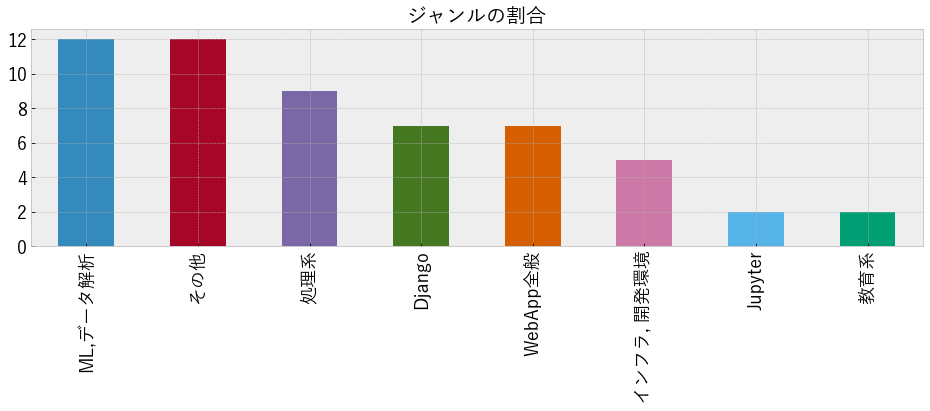

In [146]:
ax = df['genre_str'].value_counts().plot(kind='bar', fontsize=18)
ax.set_title('ジャンルの割合', fontsize=20)

Text(0.5,1,'言語の割合')

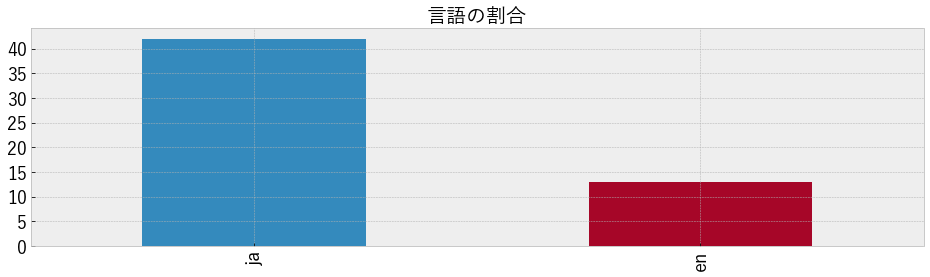

In [118]:
ax = df['lang_of_talk'].value_counts().plot(kind='bar', fontsize=18)
ax.set_title('言語の割合', fontsize=20)

In [119]:
len(dates)

9

In [132]:
talk_format_dict2 = {
 '1日目 13:30 - 14:15': 45,
 '1日目 14:30 - 15:15': 45,
 '1日目 15:45 - 16:15': 30,
 '1日目 16:30 - 17:00': 30,
 '2日目 11:15 - 12:00': 45,
 '2日目 13:30 - 14:15': 45,
 '2日目 14:30 - 15:00': 30,
 '2日目 15:45 - 16:15': 30,
 '2日目 16:30 - 17:00': 30
}

In [147]:
from matplotlib.ticker import MaxNLocator

Text(0.5,0.98,'時間帯ごとの言語の割合')

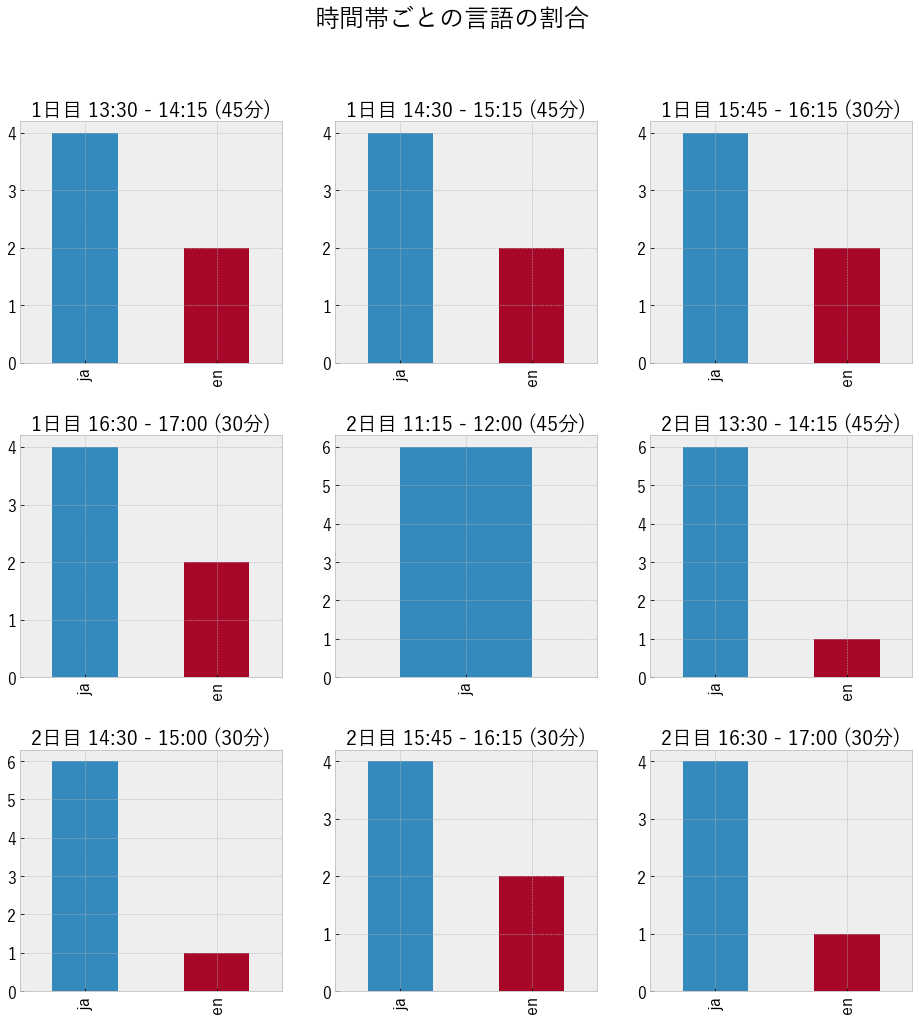

In [148]:
fig = plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.3)
for i, date_ in enumerate(dates):
    foramt = talk_format_dict2[date_]
    ax = fig.add_subplot(3, 3, i+1)
    df.query('date == @date_')['lang_of_talk'].value_counts().plot(kind='bar', ax=ax, fontsize=16)
    ax.set_title(f'{date_} ({foramt}分)', fontsize=20)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.suptitle('時間帯ごとの言語の割合', fontsize=25)

Text(0.5,0.98,'時間帯ごとのジャンルの割合')

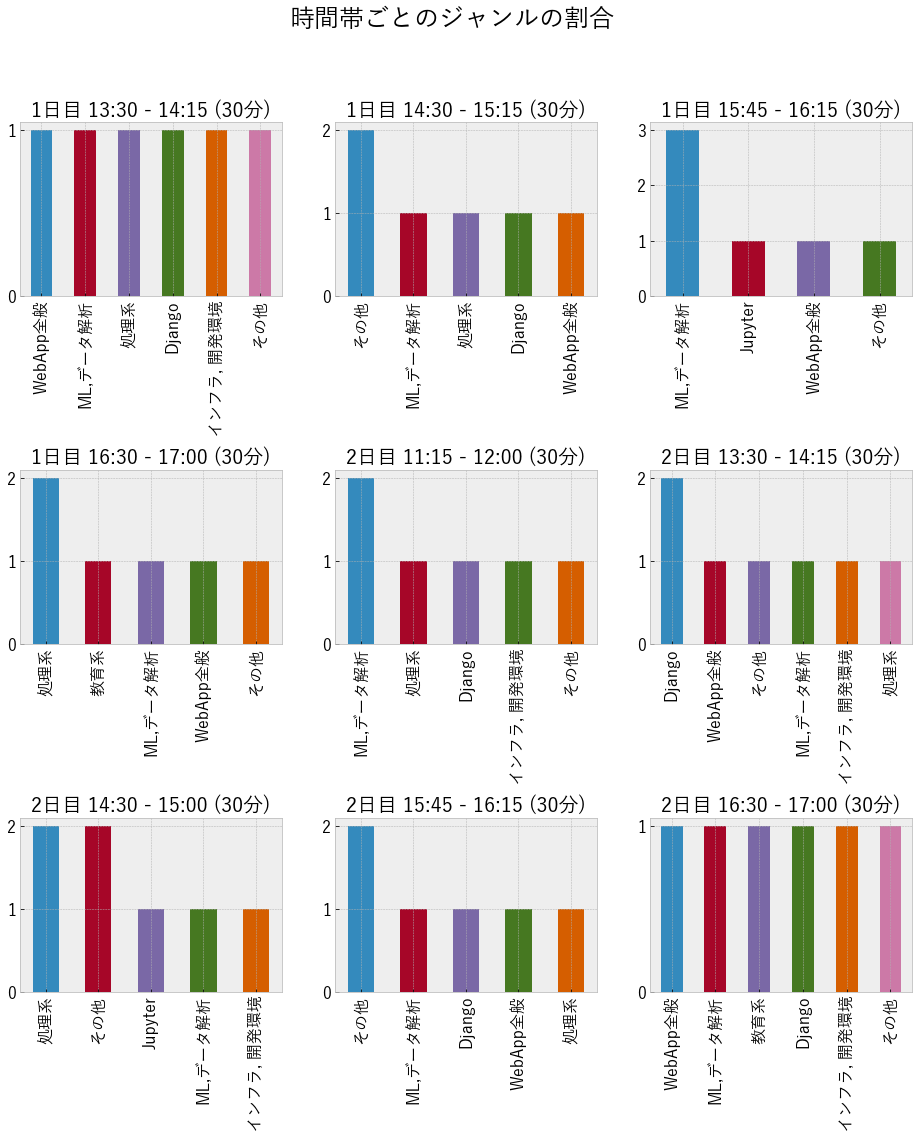

In [149]:
fig = plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=1)
for i, date_ in enumerate(dates):
    ax = fig.add_subplot(3, 3, i+1)
    df.query('date == @date_')['genre_str'].value_counts().plot(kind='bar', ax=ax, fontsize=16)
    ax.set_title(f'{date_} ({foramt}分)', fontsize=20)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.suptitle('時間帯ごとのジャンルの割合', fontsize=25)